# Simulator: Optimal and Naive Protocols

This notebook goes over the use of the simulator class to simulate both 'naive' and optimal (in the linear-response sense) control protocols, as well as introduces the concept of how to extend the simulator interface to simulate more exotic time-dependent behaviour

In [24]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plot_dir = Path().resolve().parents[1] / 'figures' / 'reports'
sns.set(style='darkgrid', palette='hls')

from fokker_planck.simulator.simulator import BreathingSimulator
from fokker_planck.types.basetypes import BoundaryCondition
import fokker_planck.forceFunctions as ff

# Here we use the same configuration parameters from the fucntionality notebook 05
config = {
    "D": 1.0,
    "dx": 0.05,
    "dt": 0.0005,
    "x_min": -4.5,
    "x_max": 4.5,
    "boundary_cond": BoundaryCondition.HardWall
}

In this example, we know the functional form of the so-called generalized friction coefficient, which varies with trap strength as

$$ \zeta(\lambda) \propto k^{-3} $$

which implies that an optimal, minimum-dissipation protocol will proceed with a control parameter veolcity

$$ \dot{\lambda}_{\rm opt} \propto \zeta^{-1/2} = k^{3/2} $$

Where the proportionality is fixed by the constraint that the protocol be completed in a fixed total time $\tau$.

In this model, we simply need to provide a function to the ```DynamicSimulator1D``` subclass called ```build_friction_array``` that will generate the friction value, as a function of control parameter (```self.lambda_array```) and the parent class contains the logic necessary to actually complete the protocol.

In [2]:
# To actually simulate the system, we need to create a simulator object
# Initial and final trap strengths
k_i, k_f = 0.5, 4.0

simulator_naive = BreathingSimulator(
    config, k_i, k_f, ff.harmonic_force, ff.harmonic_energy
)

simulator_opt = BreathingSimulator(
    config, k_i, k_f, ff.harmonic_force, ff.harmonic_energy
)

In [3]:
# And then we can run the simulation for both naive (constant velocity)
# and optimized (constant dissipation rate) protocols

result_naive = simulator_naive.run_simulation(tau=4.0, mode="naive")
result_optimal = simulator_opt.run_simulation(tau=4.0, mode="optimal")

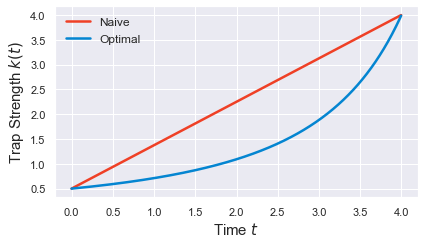

In [4]:
# Both of these results are SimulationResult objects

# To look at the control protocols in detail, we can plot them
result_optimal.__dict__.keys()
fig, ax = plt.subplots(1, 1, figsize=(6.0, 3.5))

ax.plot(result_naive.time, result_naive.CP, label="Naive", color=sns.xkcd_rgb["tomato"], linewidth=2.5)
ax.plot(result_optimal.time, result_optimal.CP, label="Optimal", color=sns.xkcd_rgb["cerulean"], linewidth=2.5)

ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"Time $t$", fontsize=15)
ax.set_ylabel(r"Trap Strength $k(t)$", fontsize=15)
plt.tight_layout()
plt.show()

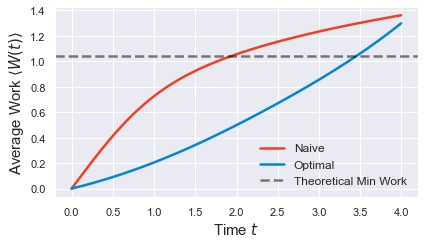

In [9]:
# We can also look at the average work required to complete these protocols
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(
    result_naive.time, result_naive._sim.work,
    color=sns.xkcd_rgb['tomato'], linewidth=2.5, label="Naive"
)
ax.plot(
    result_optimal.time, result_optimal._sim.work,
    color=sns.xkcd_rgb['cerulean'], linewidth=2.5, label="Optimal"
)

min_work = 0.5 * np.log(k_f / k_i)
ax.axhline(min_work, linewidth=2.5, linestyle='--', color='k', alpha=0.5, label='Theoretical Min Work')

ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"Time $t$", fontsize=15)
ax.set_ylabel(r"Average Work $\langle W(t) \rangle$", fontsize=15)
plt.tight_layout()
plt.show()


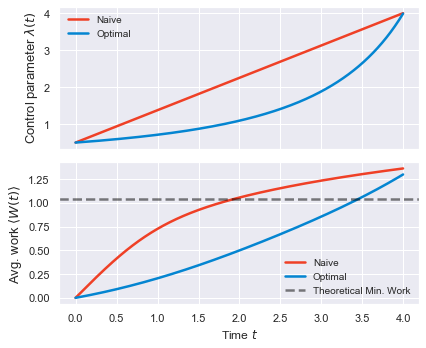

In [25]:
# Combined figure to show in repo
fig, ax = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax[0].plot(
    result_naive.time, result_naive.CP, label="Naive",
    color=sns.xkcd_rgb["tomato"], linewidth=2.5
)
ax[0].plot(
    result_optimal.time, result_optimal.CP, label="Optimal",
    color=sns.xkcd_rgb["cerulean"], linewidth=2.5
)

ax[1].plot(
    result_naive.time, result_naive._sim.work,
    color=sns.xkcd_rgb['tomato'], linewidth=2.5, label="Naive"
)
ax[1].plot(
    result_optimal.time, result_optimal._sim.work,
    color=sns.xkcd_rgb['cerulean'], linewidth=2.5, label="Optimal"
)

ax[1].axhline(min_work, linewidth=2.5, linestyle='--', color='k', alpha=0.5, label='Theoretical Min. Work')

ax[0].set_ylabel(r"Control parameter $\lambda(t)$", fontsize=13)
ax[1].set_ylabel(r"Avg. work $\langle W(t) \rangle$", fontsize=13)
ax[1].set_xlabel(r"Time $t$", fontsize=12)
ax[0].legend(fontsize=10, frameon=False)
ax[1].legend(fontsize=10, frameon=False)
plt.tight_layout()
plt.savefig(plot_dir / "breathing_trap_opt.pdf")
plt.savefig(plot_dir / "breathing_trap_opt.png", dpi=600)

plt.show()



In [12]:
(result_naive._sim.total_work - min_work) / (result_optimal._sim.total_work - min_work)

1.2363413789778208

From this result, we can see that the 'optimal' protocol seems to accumulate power at a more constant rate than the naive alternative. Theoretically (within the linear-response approximation) the excess power (work accumulation) should be constant. However, because it is *excess* work that is constant, we would need to take out the changes in free energy from the raw work accumulation to get a full picture. Nonetheless, we can see that the total work required for the optimal protocol is reduced relative to the naive alternative, and that the increase in work in the naive protocol relative to the optimal (taking into account the theoretical minimum value shown by the dashed line) is about 25%.

For a more in-depth investigation of this particular system, and a derivation/rationalization for the minimum work bound see the notebook at `functionality/05-breathing-trap.ipynb`